In [37]:
import os

In [38]:
os.chdir("C:/Users/dsuan/Documents/BC3")

In [39]:
import pandas as pd
import numpy as np
from scipy.stats import norm
from datetime import datetime
import requests
from io import BytesIO

import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sb
import statsmodels.api as sm
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pnd
import matplotlib.pyplot as mplt
import seaborn as sbn
import datetime
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from pandas.core.groupby.grouper import get_grouper
from statsmodels.tsa.arima_model import ARIMA
sbn.set(rc={'figure.figsize':(10, 5)})
%matplotlib inline
pd.set_option('precision',2)

In [40]:
data = pd.read_csv("python.txt")
data = pd.DataFrame(data)
dates= pd.Series(pd.date_range(start='2018/01/01', periods =32, freq ='M'))


In [41]:
rate = {10:1,
        12:1,
        21:0,
        22:0
       }

In [42]:
educ_type = {71:1,
         73:2,
        111:3,
        123:4,
        124:4,
        125:4     
       }


In [43]:
work_type ={13:1, 14:1, 22:2, 23:2, 25:3,26:3,27:3,28:3}

In [44]:
data["NewEMPSTAT"] = data["EMPSTAT"].map(rate)
data["NewEDUC"] = data["EDUC"].map(educ_type)
data["NewClassW"] = data["CLASSWKR"].map(work_type)
#reemplazar los valores missing por NAN.
data["EARNWEEK"].replace(to_replace=9999.99, value = np.nan, inplace = True)
data["AHRSWORKT"].replace(to_replace=999, value = np.nan, inplace = True)

data.head(5)

,YEAR,SERIAL,MONTH,HWTFINL,CPSID,PERNUM,WTFINL,CPSIDP,EMPSTAT,LABFORCE,OCC,IND,CLASSWKR,AHRSWORKT,WHYUNEMP,EDUC,EARNWEEK,NewEMPSTAT,NewEDUC,NewClassW
0,2018,1,1,1490.59,20161000000100,1,2158.95,20161000000101,32,1,0,0,0,NaN,0,92,NaN,NaN,NaN,NaN
1,2018,1,1,1490.59,20161000000100,2,1490.59,20161000000102,36,1,0,0,0,NaN,0,81,NaN,NaN,NaN,NaN
2,2018,2,1,1609.49,20161200000200,1,1420.75,20161200000201,10,2,9140,7580,22,55.0,0,81,NaN,1.0,NaN,2.0
3,2018,2,1,1609.49,20161200000200,2,1609.49,20161200000202,36,1,0,0,0,NaN,0,81,NaN,NaN,NaN,NaN
4,2018,3,1,1797.04,20180100000300,1,2053.27,20180100000301,10,2,4920,7070,13,10.0,0,111,NaN,1.0,3.0,1.0


In [45]:
employment = data[data["NewEMPSTAT"]==1]

In [46]:
employment = employment.groupby(["YEAR","MONTH"])["NewEMPSTAT"].count()

In [47]:
unemployment = data[data["NewEMPSTAT"]==0]

In [48]:
unemployment = unemployment.groupby(["YEAR","MONTH"])["NewEMPSTAT"].count()

In [49]:
ratio = employment / (employment+unemployment)
ratio.head()

YEAR  MONTH
2018  1        0.96
      2        0.96
      3        0.96
      4        0.96
      5        0.97
Name: NewEMPSTAT, dtype: float64

In [83]:
ratio = pd.DataFrame(ratio)
ratio = ratio.reset_index().drop(["YEAR","MONTH"], axis=1)


Text(0.5, 1.0, 'Tendence Employmente Rate')

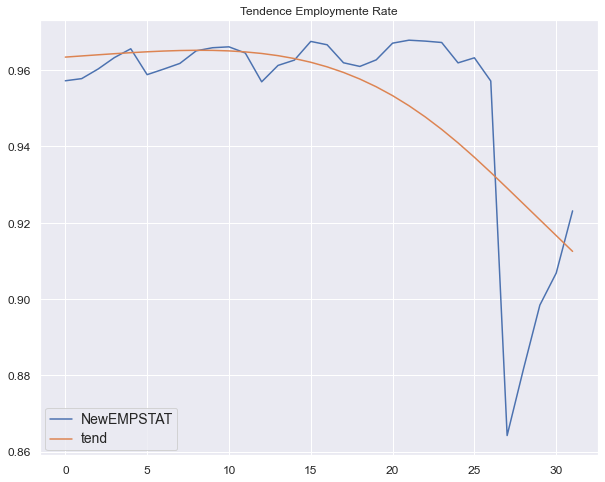

In [84]:
# Aplicando el filtro Hodrick-Prescott para separar en tendencia y 
# componente ciclico.
ratio_ciclo, ratio_tend = sm.tsa.filters.hpfilter(ratio['NewEMPSTAT'])
ratio['tend'] = ratio_tend
# graficando la variacion del precio real con la tendencia.
ratio[['NewEMPSTAT', 'tend']].plot(figsize=(10, 8), fontsize=12);
legend = plt.legend()
legend.prop.set_size(14);
plt.title('Tendence Employmente Rate')


Text(0.5, 1.0, 'Employment Rate (% Mensual Change)')

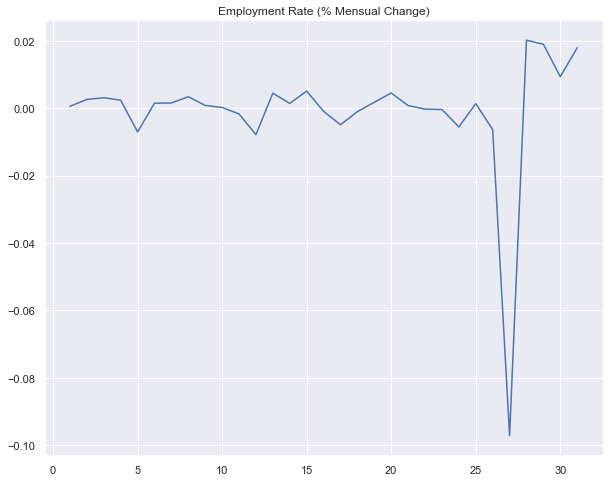

In [85]:
# calculando el porcentaje de variación del día.
variacion_mensual = ratio['NewEMPSTAT'] / ratio['NewEMPSTAT'].shift(1) - 1
ratio['var_mensual'] = variacion_mensual
ratio['var_mensual'][:5]
# graficando rendimiento diario
plot = ratio['var_mensual'].plot(figsize=(10, 8))
plt.title("Employment Rate (% Mensual Change)")

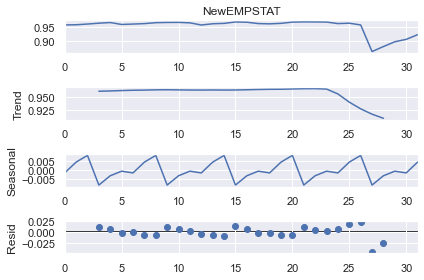

In [86]:
descomposicion = sm.tsa.seasonal_decompose(ratio['NewEMPSTAT'],
                                                  model='additive', period=6)  
fig = descomposicion.plot()

In [87]:
ratio["NewEMPSTAT1"] = ratio["NewEMPSTAT"]
list = [ratio["NewEMPSTAT"].iloc[i]  for i in range(7)]
for i in range (7):
    ratio["NewEMPSTAT1"].iloc[-i+1] = list[i]


Text(0, 0.5, 'Rate')

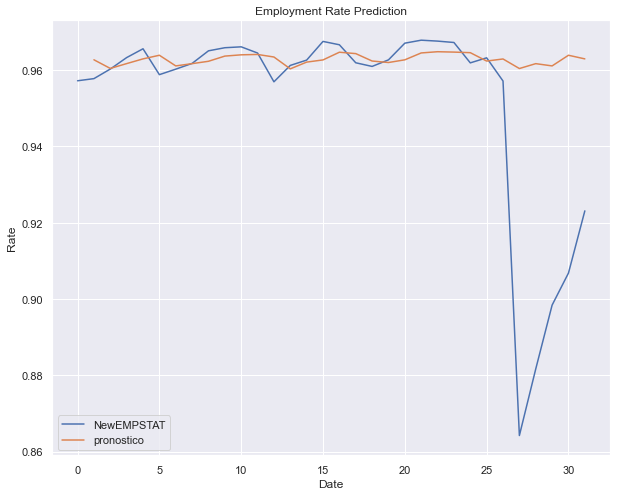

In [88]:
# Modelo ARIMA sobre el valor de cierre de la acción.
modelo = sm.tsa.ARIMA(ratio['NewEMPSTAT1'].iloc[1:], order=(1, 0, 0))  
resultados = modelo.fit(disp=-1)  
ratio['pronostico'] = resultados.fittedvalues  
plot = ratio[['NewEMPSTAT', 'pronostico']].plot(figsize=(10, 8))
plt.title("Employment Rate Prediction")
plt.xlabel("Date")
plt.ylabel("Rate")

## EDUCATION RATE 

Text(0.5, 1.0, 'Employment Rate by Education Level')

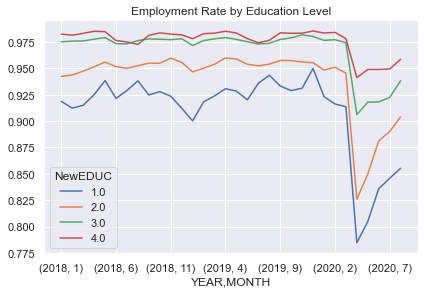

In [89]:
EDUC1=data.groupby(["YEAR","MONTH","NewEDUC"]).mean()["NewEMPSTAT"].unstack()
EDUC1.plot(kind="line")
plt.tight_layout()
plt.title("Employment Rate by Education Level")
 

## WEEKLY HOURS

In [90]:
Average_ho =data.groupby(["YEAR","MONTH"])["AHRSWORKT"].mean()
Average_ho.head()

YEAR  MONTH
2018  1        38.33
      2        38.56
      3        38.65
      4        39.04
      5        39.20
Name: AHRSWORKT, dtype: float64

In [94]:
Average_ho = Average_ho.reset_index().drop(["YEAR","MONTH"], axis=1)

In [95]:
Average_ho_ciclo, Average_ho_tend = sm.tsa.filters.hpfilter(Average_ho['AHRSWORKT'])
Average_ho['tend'] = Average_ho_tend

Text(0.5, 1.0, 'Moving Average')

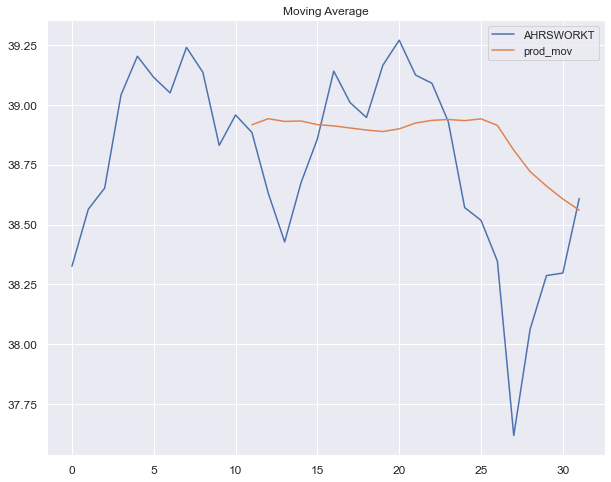

In [96]:
Average_ho_ma = Average_ho['AHRSWORKT'].rolling(12).mean()
Average_ho['prod_mov'] = Average_ho_ma
plot = Average_ho[['AHRSWORKT', 'prod_mov']].plot(figsize=(10, 8), fontsize=12)
plt.title('Moving Average')

Text(0.5, 1.0, 'Tendence Employmente Rate')

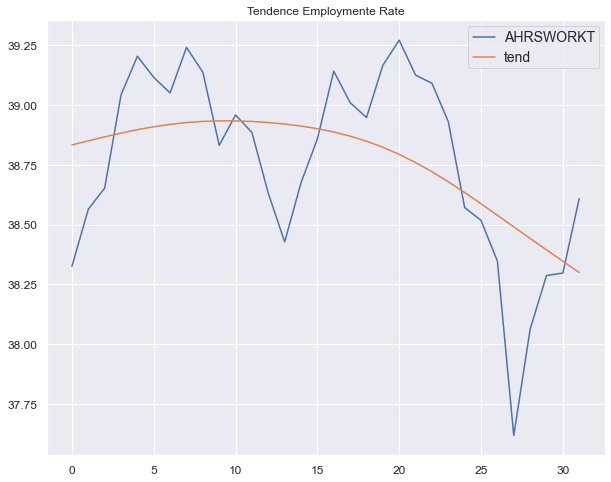

In [97]:
# graficando la variacion del precio real con la tendencia.
Average_ho[['AHRSWORKT', 'tend']].plot(figsize=(10, 8), fontsize=12);
legend = plt.legend()
legend.prop.set_size(14);
plt.title('Tendence Employmente Rate')

Text(0.5, 1.0, 'Average Hours (% Mensual Change)')

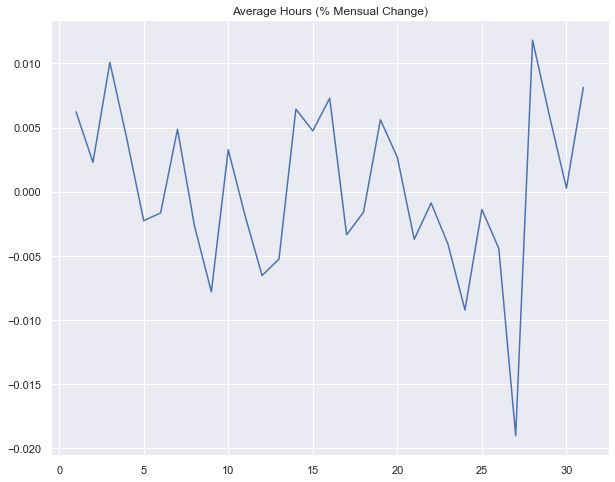

In [98]:
# calculando el porcentaje de variación del día.
variacion_mensual = Average_ho['AHRSWORKT'] / Average_ho['AHRSWORKT'].shift(1) - 1
Average_ho['var_mensual'] = variacion_mensual
Average_ho['var_mensual'][:5]
# graficando rendimiento diario
plot = Average_ho['var_mensual'].plot(figsize=(10, 8))
plt.title("Average Hours (% Mensual Change)")

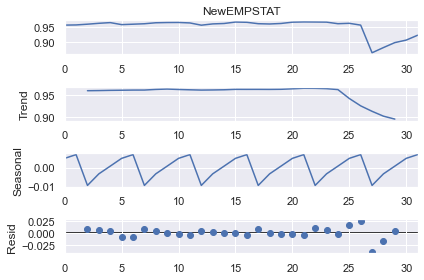

In [99]:
descomposicion = sm.tsa.seasonal_decompose(ratio['NewEMPSTAT'],
                                                  model='additive', period=5)  
fig = descomposicion.plot()

In [100]:
Average_ho["AHRSWORKT1"] = Average_ho["AHRSWORKT"]
list = [Average_ho["AHRSWORKT"].iloc[i]  for i in range(7)]
for i in range (7):
    Average_ho["AHRSWORKT1"].iloc[-i-1] = list[i]


Text(0.5, 1.0, 'Average Weekly Hours Predicition1')

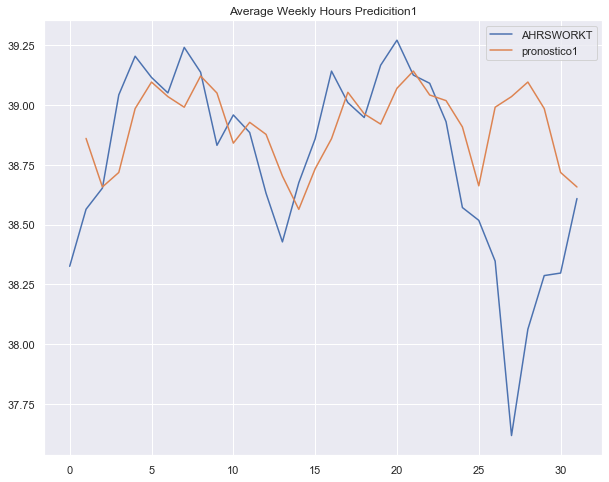

In [153]:
# Modelo ARIMA sobre el valor de cierre de la acción.
modelo = sm.tsa.ARIMA(Average_ho['AHRSWORKT1'].iloc[1:], order=(1, 0, 0))  
resultados = modelo.fit(disp=-1)  
Average_ho['pronostico1'] = resultados.fittedvalues  
plot = Average_ho[['AHRSWORKT', 'pronostico1']].plot(figsize=(10, 8)) 
plt.title("Average Weekly Hours Predicition1")

Text(0.5, 1.0, 'Average Weekly Hours by Worker Class')

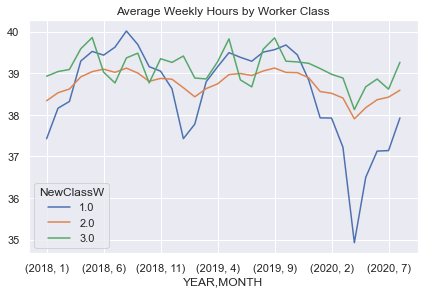

In [102]:
Average_ho_W = data.groupby(["YEAR","MONTH","NewClassW"]).mean()["AHRSWORKT"].unstack()
Average_ho_W.plot(kind="line")
plt.tight_layout()
plt.title("Average Weekly Hours by Worker Class")

Text(0.5, 1.0, 'Average Weekly Hours by Education Level')

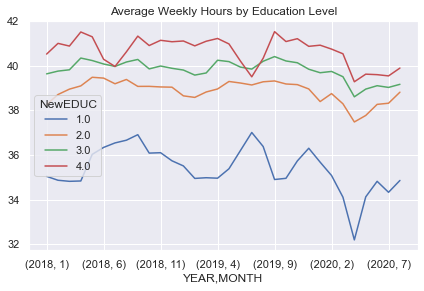

In [103]:
Average_ho_Educ = data.groupby(["YEAR","MONTH","NewEDUC"]).mean()["AHRSWORKT"].unstack()
Average_ho_Educ.plot(kind="line")
plt.tight_layout()
plt.title("Average Weekly Hours by Education Level")

## RATE BY INDUSTRY

In [104]:
data_2 = pd.read_csv("Data_2.txt")

In [105]:
data_2.drop(data_2[(data_2["WRKHOMEABLE"] == 99)
                       | (data_2["WRKHOMEABLE"] == 98)
                       | (data_2["IND_CPS8"] == 9999)
                       | (data_2["IND_CPS8"] == 99999)].index, inplace=True)
data_2 = data_2.dropna()
data_2.head()

,YEAR,CASEID,PERNUM,LINENO,WT06,OCC2_CPS8,IND2_CPS8,IND_CPS8,WRKHOMEABLE
5,2018,20180101180087,1,1,7.06e+06,130,251,8270,0.0
8,2018,20180101180145,1,1,3.90e+06,150,251,8170,1.0
11,2018,20180101180507,1,1,6.84e+06,140,131,2980,1.0
15,2018,20180101180532,1,1,3.83e+06,110,220,7380,1.0
17,2018,20180101180549,1,1,6.95e+06,111,9999,6672,1.0


In [106]:
a = data_2.groupby("IND_CPS8")["WRKHOMEABLE"].sum()
a

IND_CPS8
170      3.0
180      4.0
190      2.0
270      2.0
290      1.0
        ... 
9470    22.0
9480    17.0
9490    11.0
9570    15.0
9590    11.0
Name: WRKHOMEABLE, Length: 238, dtype: float64

In [107]:
b = data_2.groupby("IND_CPS8")["WRKHOMEABLE"].count()
b

IND_CPS8
170     15
180     17
190      2
270      4
290      4
        ..
9470    97
9480    42
9490    24
9570    27
9590    34
Name: WRKHOMEABLE, Length: 238, dtype: int64

In [108]:
c=a/b
c


IND_CPS8
170     0.20
180     0.24
190     1.00
270     0.50
290     0.25
        ... 
9470    0.23
9480    0.40
9490    0.46
9570    0.56
9590    0.32
Name: WRKHOMEABLE, Length: 238, dtype: float64

In [109]:
c = c.sort_values()
c

IND_CPS8
4280    0.0
2890    0.0
1670    0.0
1880    0.0
5390    0.0
       ... 
190     1.0
1390    1.0
7880    1.0
6672    1.0
4265    1.0
Name: WRKHOMEABLE, Length: 238, dtype: float64

In [110]:
tele_work_key = c.to_dict()

In [111]:
data_2["Index_TeleWork"] = data_2["IND_CPS8"].map(tele_work_key)
data_2.head()

,YEAR,CASEID,PERNUM,LINENO,WT06,OCC2_CPS8,IND2_CPS8,IND_CPS8,WRKHOMEABLE,Index_TeleWork
5,2018,20180101180087,1,1,7.06e+06,130,251,8270,0.0,0.19
8,2018,20180101180145,1,1,3.90e+06,150,251,8170,1.0,0.28
11,2018,20180101180507,1,1,6.84e+06,140,131,2980,1.0,0.20
15,2018,20180101180532,1,1,3.83e+06,110,220,7380,1.0,0.85
17,2018,20180101180549,1,1,6.95e+06,111,9999,6672,1.0,1.00


In [112]:
yes_telework = data_2[data_2["Index_TeleWork"] >= 0.50]
no_telework = data_2[data_2["Index_TeleWork"] < 0.50]
yes_telework["IND_CPS8"].keys

<bound method Series.keys of 15      7380
17      6672
18      7270
21      7280
49      4195
        ... 
9524    6670
9543    9160
9549    6990
9566    7870
9577    6990
Name: IND_CPS8, Length: 1288, dtype: int64>

In [113]:
te_keys = dict.fromkeys(yes_telework["IND_CPS8"], 1)
te_keys.update(dict.fromkeys(no_telework["IND_CPS8"], 0))
data["Telework_Yes"] = data["IND"].map(te_keys)
data


,YEAR,SERIAL,MONTH,HWTFINL,CPSID,PERNUM,WTFINL,CPSIDP,EMPSTAT,LABFORCE,...,IND,CLASSWKR,AHRSWORKT,WHYUNEMP,EDUC,EARNWEEK,NewEMPSTAT,NewEDUC,NewClassW,Telework_Yes
0,2018,1,1,1490.59,20161000000100,1,2158.95,20161000000101,32,1,...,0,0,NaN,0,92,NaN,NaN,NaN,NaN,NaN
1,2018,1,1,1490.59,20161000000100,2,1490.59,20161000000102,36,1,...,0,0,NaN,0,81,NaN,NaN,NaN,NaN,NaN
2,2018,2,1,1609.49,20161200000200,1,1420.75,20161200000201,10,2,...,7580,22,55.0,0,81,NaN,1.0,NaN,2.0,0.0
3,2018,2,1,1609.49,20161200000200,2,1609.49,20161200000202,36,1,...,0,0,NaN,0,81,NaN,NaN,NaN,NaN,NaN
4,2018,3,1,1797.04,20180100000300,1,2053.27,20180100000301,10,2,...,7070,13,10.0,0,111,NaN,1.0,3.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3732421,2020,68628,8,424.04,20200806862800,7,321.10,20200806862807,10,2,...,8680,22,34.0,0,81,NaN,1.0,NaN,2.0,0.0
3732422,2020,68629,8,431.80,20200706863600,1,428.07,20200706863601,21,2,...,490,22,NaN,2,73,NaN,0.0,2.0,2.0,0.0
3732423,2020,68629,8,431.80,20200706863600,2,431.80,20200706863602,34,1,...,0,0,NaN,0,92,NaN,NaN,NaN,NaN,NaN
3732424,2020,68629,8,431.80,20200706863600,3,374.66,20200706863603,0,0,...,0,0,NaN,0,1,NaN,NaN,NaN,NaN,NaN


Text(0.5, 1.0, 'Employment Rate by Ability to Telework')

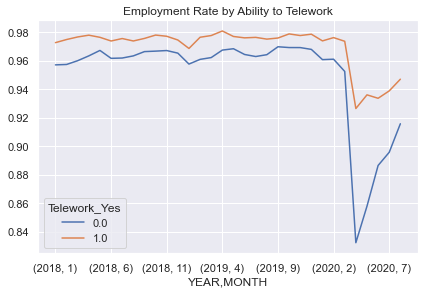

In [114]:
Tele_W=data.groupby(["YEAR","MONTH","Telework_Yes"]).mean()["NewEMPSTAT"].unstack()
Tele_W.plot(kind="line")
plt.tight_layout()
plt.title("Employment Rate by Ability to Telework")

Text(0.5, 1.0, 'Average Weekly Hours by Ability to Telework')

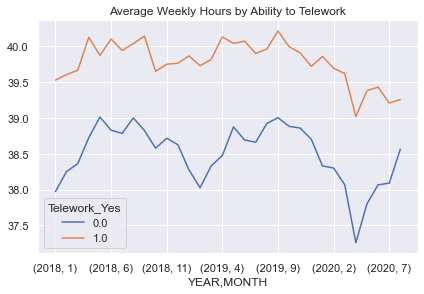

In [115]:
A_Hour_Tele_W=data.groupby(["YEAR","MONTH","Telework_Yes"]).mean()["AHRSWORKT"].unstack()
A_Hour_Tele_W.plot(kind="line")
plt.tight_layout()
plt.title("Average Weekly Hours by Ability to Telework")

Text(0.5, 1.0, 'Average Weekly Earnings by Ability to Telework')

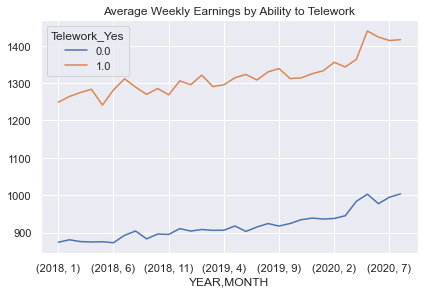

In [116]:
A_Earn_Tele_W=data.groupby(["YEAR","MONTH","Telework_Yes"]).mean()["EARNWEEK"].unstack()
A_Earn_Tele_W.plot(kind="line")
plt.tight_layout()
plt.title("Average Weekly Earnings by Ability to Telework")

## Employment Rate by Worker Class

Text(0.5, 1.0, 'Employment Rate by Worker Type')

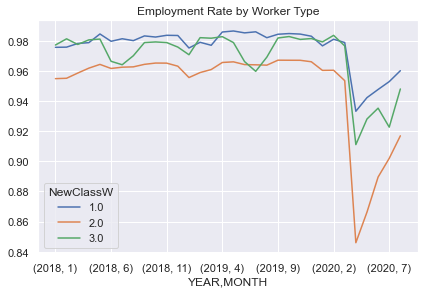

In [117]:
ClassW=data.groupby(["YEAR","MONTH","NewClassW"]).mean()["NewEMPSTAT"].unstack()
ClassW.plot(kind="line")
plt.tight_layout()
plt.title("Employment Rate by Worker Type")

## Average Rate  by Class of Worker

Text(0.5, 1.0, 'Average Weekly Hours by Worker Type ')

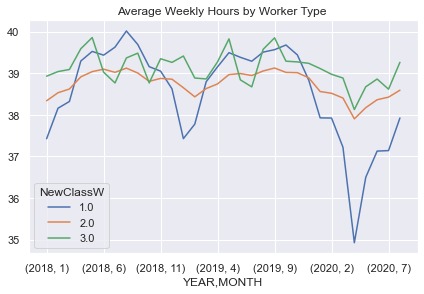

In [118]:
Average_W = data.groupby(["YEAR","MONTH","NewClassW"]).mean()["AHRSWORKT"].unstack()
Average_W .plot(kind="line")
plt.tight_layout()
plt.title("Average Weekly Hours by Worker Type ")

## Earnings

In [119]:
Wage1 = data.groupby(["YEAR","MONTH"])["EARNWEEK"].mean()
Wage1.head()

YEAR  MONTH
2018  1        957.69
      2        967.94
      3        967.68
      4        966.88
      5        959.13
Name: EARNWEEK, dtype: float64

Text(0.5, 1.0, 'Moving Average')

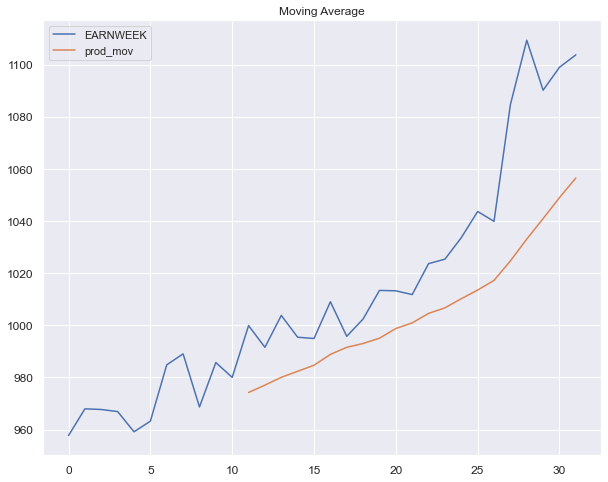

In [124]:
Wage1_ma = Wage1['EARNWEEK'].rolling(12).mean()
Wage1['prod_mov'] = Wage1_ma
plot = Wage1[['EARNWEEK', 'prod_mov']].plot(figsize=(10, 8), fontsize=12)
plt.title('Moving Average')

In [126]:
Wage1 = pd.DataFrame(Wage1)
#Wage1 = Wage1.reset_index().drop(["YEAR","MONTH"], axis=1)

In [127]:
# Aplicando el filtro Hodrick-Prescott para separar en tendencia y 
# componente ciclico.
Wage1_ciclo, Wage1_tend = sm.tsa.filters.hpfilter(Wage1['EARNWEEK'])
Wage1['tend'] = Wage1_tend

Text(0.5, 1.0, 'Tendence of Earnings')

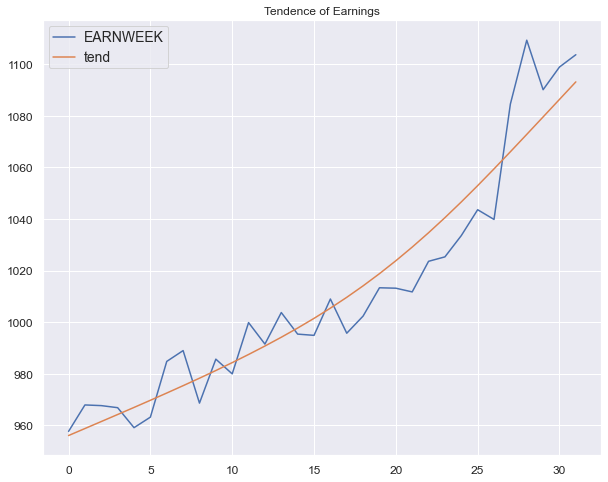

In [128]:
# graficando la variacion del precio real con la tendencia.
Wage1[['EARNWEEK', 'tend']].plot(figsize=(10, 8), fontsize=12);
legend = plt.legend()
legend.prop.set_size(14);
plt.title('Tendence of Earnings')

Text(0.5, 1.0, 'Earnings (% Mensual Change)')

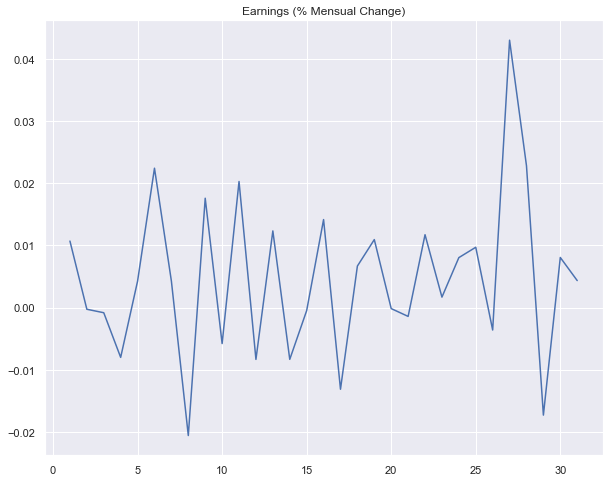

In [129]:
# calculando el porcentaje de variación del día.
variacion_diaria = Wage1['EARNWEEK'] / Wage1['EARNWEEK'].shift(1) - 1
Wage1['var_diaria'] = variacion_diaria
Wage1['var_diaria'][:5]
# graficando rendimiento diario
plot = Wage1['var_diaria'].plot(figsize=(10, 8))
plt.title("Earnings (% Mensual Change)")

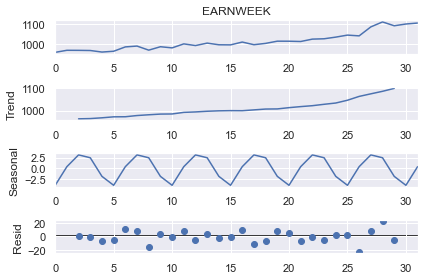

In [130]:
descomposicion = sm.tsa.seasonal_decompose(Wage1['EARNWEEK'],
                                                  model='additive', period=5)  
fig = descomposicion.plot()

In [131]:
Wage1["EARNWEEK1"] = Wage1["EARNWEEK"]
list = [Wage1["EARNWEEK"].iloc[i]  for i in range(7)]
for i in range (7):
    Wage1["EARNWEEK1"].iloc[-i+1] = list[i]


Text(0.5, 1.0, 'Prediction Earnings')

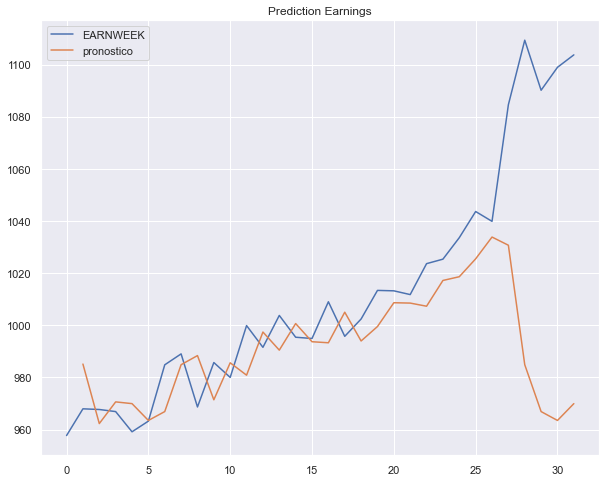

In [132]:
# Modelo ARIMA sobre el valor de cierre de la acción.
modelo = sm.tsa.ARIMA(Wage1['EARNWEEK1'].iloc[1 :], order=(1, 0, 0))  
resultados = modelo.fit(disp=-1)  
Wage1['pronostico'] = resultados.fittedvalues  
plot = Wage1[['EARNWEEK', 'pronostico']].plot(figsize=(10, 8))  
plt.title('Prediction Earnings')

Text(0.5, 1.0, 'Weekly Earnings by Worker Class')

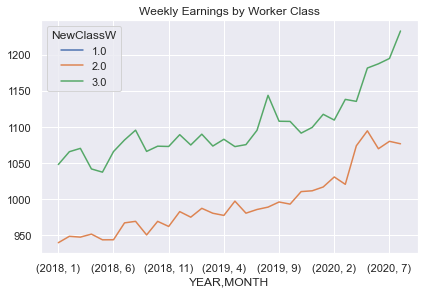

In [133]:
Earning_W = data.groupby(["YEAR","MONTH","NewClassW"]).mean()["EARNWEEK"].unstack()
Earning_W.plot(kind="line")
plt.tight_layout()
plt.title("Weekly Earnings by Worker Class")

Text(0.5, 1.0, 'Weekly Earnings by Education Level')

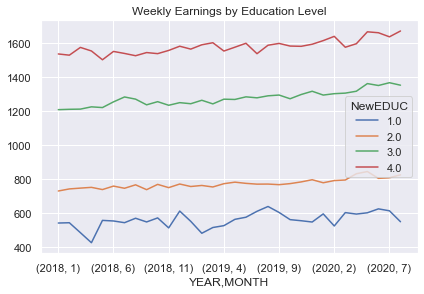

In [134]:
Earning_Educ = data.groupby(["YEAR","MONTH","NewEDUC"]).mean()["EARNWEEK"].unstack()
Earning_Educ.plot(kind="line")
plt.tight_layout()
plt.title("Weekly Earnings by Education Level")

## Spain Data 

In [135]:

datas = pd.read_csv("DATA_ESP2.txt")

In [136]:
datas1 = pd.read_csv("Data_ESP.txt")

## Employment Rate of Spain

Text(0.5, 1.0, 'Tendence Employmente Rate of Spain')

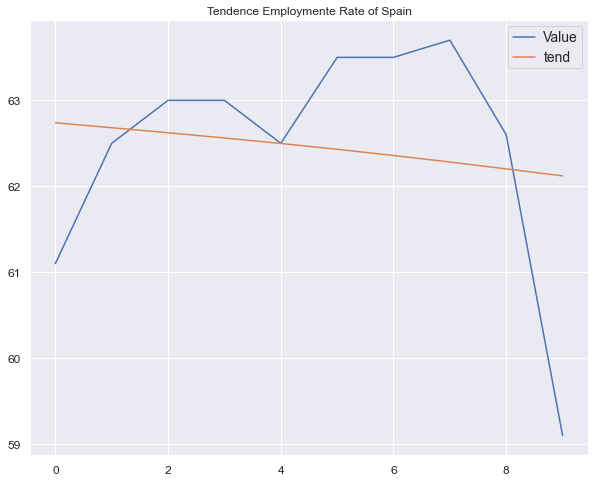

In [137]:
# Aplicando el filtro Hodrick-Prescott para separar en tendencia y 
# componente ciclico.
datas1_ciclo, datas1_tend = sm.tsa.filters.hpfilter(datas1['Value'])
datas1['tend'] = datas1_tend
# graficando la variacion del precio real con la tendencia.
datas1[['Value', 'tend']].plot(figsize=(10, 8), fontsize=12);
legend = plt.legend()
legend.prop.set_size(14);
plt.title('Tendence Employmente Rate of Spain')

Text(0.5, 1.0, 'Employment Rate of Spain (% Mensual Change)')

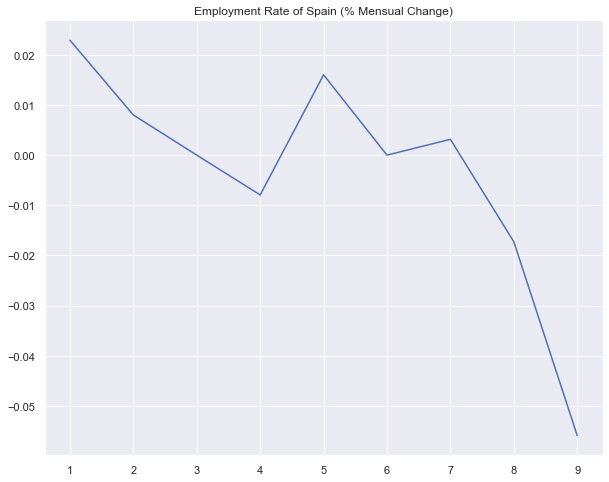

In [138]:
# calculando el porcentaje de variación del día.
variacion_mensual = datas1['Value'] / datas1['Value'].shift(1) - 1
datas1['var_mensual'] = variacion_mensual
datas1['var_mensual'][:5]
# graficando rendimiento diario
plot = datas1['var_mensual'].plot(figsize=(10, 8))
plt.title("Employment Rate of Spain (% Mensual Change)")

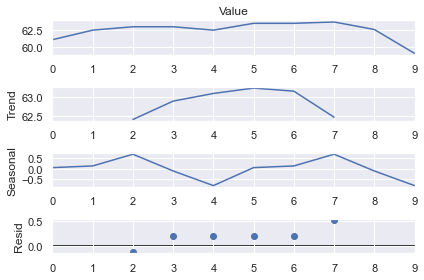

In [139]:
descomposicion = sm.tsa.seasonal_decompose(datas1['Value'],
                                                  model='additive', period=5)  
fig = descomposicion.plot()

In [140]:
datas1["Value1"] = datas1["Value"]
list = [datas1["Value"].iloc[i]  for i in range(4)]
for i in range (4):
    datas1["Value1"].iloc[-i+1] = list[i]

C:\Users\dsuan\anaconda3\lib\site-packages\pandas\core\indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


In [141]:
#datas1.set_index("TIME", inplace=True)

C:\Users\dsuan\anaconda3\lib\site-packages\statsmodels\base\model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warn('Inverting hessian failed, no bse or cov_params '


Text(0.5, 1.0, 'Employment Rate Prediction of Spain')

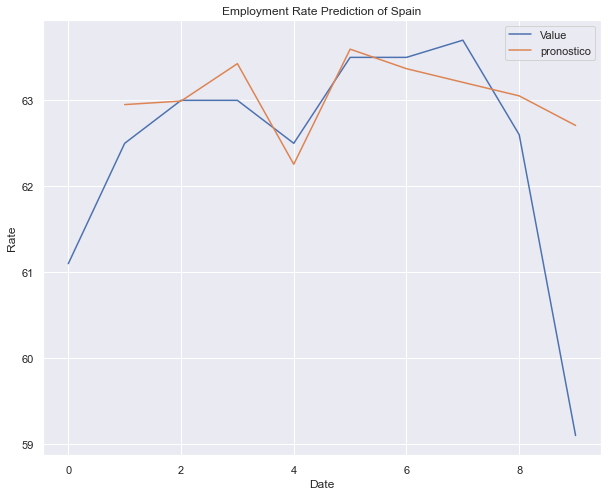

In [142]:
# Modelo ARIMA sobre el valor de cierre de la acción.
modelo = sm.tsa.ARIMA(datas1['Value1'].iloc[1 :], order=(0, 0, 5))  
resultados = modelo.fit(disp=-1)  
datas1['pronostico'] = resultados.fittedvalues  
plot = datas1[['Value', 'pronostico']].plot(figsize=(10, 8))
plt.title("Employment Rate Spain")
plt.xlabel("Date")
plt.ylabel("Rate")
plt.title('Employment Rate Prediction of Spain')

## Education Rate of Spain

In [143]:
Educ_spa = {'Less than primary, primary and lower secondary education (levels 0-2)' :1,
            'Upper secondary and post-secondary non-tertiary education (levels 3 and 4)':2,
            'Tertiary education (levels 5-8)':3         }

In [144]:
datas["NewEDUCS"] = datas["ISCED11"].map(Educ_spa)
datas.set_index("TIME", inplace=True)


Text(0.5, 1.0, 'Employment Rate by Education Level of Spain')

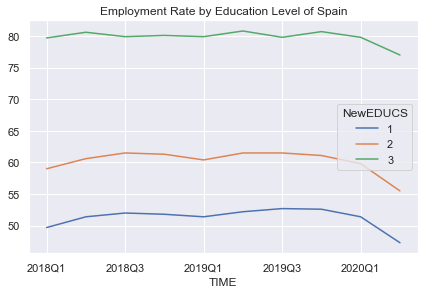

In [145]:
EDUC_Spa =datas.groupby(["TIME","NewEDUCS"]).mean()["Value"].unstack()
EDUC_Spa.plot(kind="line")
plt.tight_layout()
plt.title("Employment Rate by Education Level of Spain")

## Average Hours of Spain

In [146]:
datasH = pd.read_excel("HORAS_ESP.xlsx")
datasH

,AÑO,TRIM,HORAS,OCUPADOS,AV_HORAS
0,2018,1,615140.5,18874.2,32.59
1,2018,2,646371.0,19344.1,33.41
2,2018,3,587829.1,19528.0,30.10
3,2018,4,628650.0,19564.6,32.13
4,2019,1,638565.7,19471.1,32.80
5,2019,2,646348.3,19804.9,32.64
6,2019,3,588451.9,19874.3,29.61
7,2019,4,639961.6,19966.9,32.05
8,2020,1,612752.8,19681.3,31.13
9,2020,2,474306.8,18607.2,25.49


Text(0.5, 1.0, 'Tendence Average Hours of Spain')

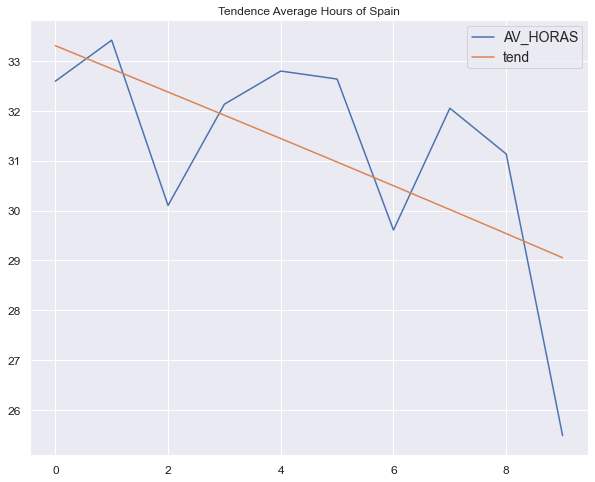

In [147]:
# Aplicando el filtro Hodrick-Prescott para separar en tendencia y 
# componente ciclico.
datasH_ciclo, datasH_tend = sm.tsa.filters.hpfilter(datasH['AV_HORAS'])
datasH['tend'] = datasH_tend
# graficando la variacion del precio real con la tendencia.
datasH[['AV_HORAS', 'tend']].plot(figsize=(10, 8), fontsize=12);
legend = plt.legend()
legend.prop.set_size(14);
plt.title('Tendence Average Hours of Spain')


Text(0.5, 1.0, 'Average Hours of Spain (% Mensual Change)')

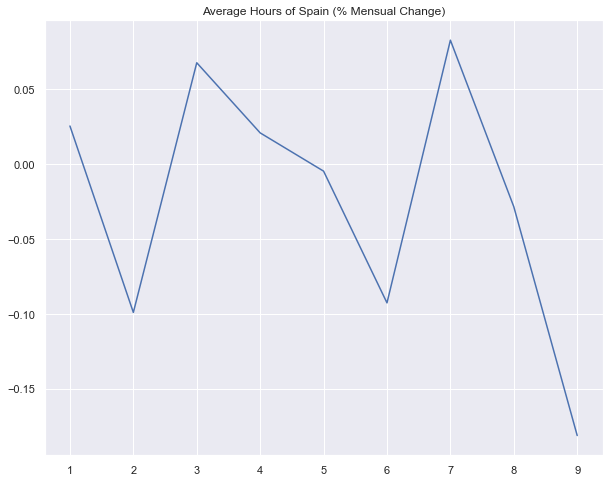

In [148]:
# calculando el porcentaje de variación del día.
variacion_Trimestral = datasH['AV_HORAS'] / datasH['AV_HORAS'].shift(1) - 1
datasH['var_Trimestral'] = variacion_Trimestral
datasH['var_Trimestral'][:5]
# graficando rendimiento diario
plot = datasH['var_Trimestral'].plot(figsize=(10, 8))
plt.title("Average Hours of Spain (% Mensual Change)")

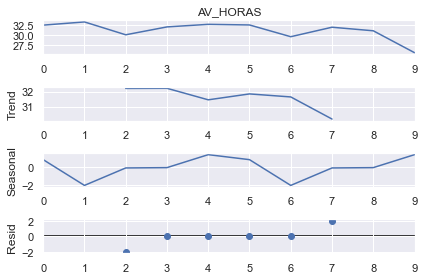

In [149]:
descomposicion = sm.tsa.seasonal_decompose(datasH['AV_HORAS'],
                                                  model='additive', period=5)  
fig = descomposicion.plot()

In [150]:
datasH["AV_HORAS1"] = datasH["AV_HORAS"]
list = [datasH["AV_HORAS"].iloc[i]  for i in range(3)]
for i in range (3):
    datasH["AV_HORAS1"].iloc[-i+1] = list[i]

C:\Users\dsuan\anaconda3\lib\site-packages\pandas\core\indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


Text(0.5, 1.0, 'Average Hours Prediction of Spain')

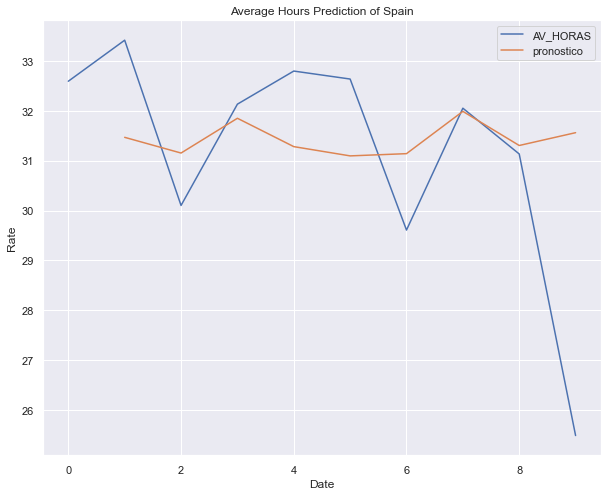

In [151]:
# Modelo ARIMA sobre el valor de cierre de la acción.
modelo = sm.tsa.ARIMA(datasH['AV_HORAS1'].iloc[1 :], order=(1, 0, 0))  
resultados = modelo.fit(disp=-1)  
datasH['pronostico'] = resultados.fittedvalues  
plot = datasH[['AV_HORAS', 'pronostico']].plot(figsize=(10, 8))
plt.xlabel("Date")
plt.ylabel("Rate")
plt.title('Average Hours Prediction of Spain')